In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
import os
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os


class ResNet20(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet20, self).__init__()
        # Use ResNet18 as base and modify for ResNet20
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, filter_suffix=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load REAL images (label 1)
        real_path = os.path.join(root_dir, 'REAL')
        for img_name in os.listdir(real_path):
            if filter_suffix:
                if not any(img_name.endswith(suffix) for suffix in filter_suffix):
                    continue
            self.images.append(os.path.join(real_path, img_name))
            self.labels.append(1)
            
        # Load FAKE images (label 0)
        fake_path = os.path.join(root_dir, 'FAKE')
        for img_name in os.listdir(fake_path):
            if filter_suffix:
                if not any(img_name.endswith(suffix) for suffix in filter_suffix):
                    continue
            self.images.append(os.path.join(fake_path, img_name))
            self.labels.append(0)
    
    def __len__(self):  # Add this method
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=3):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        
    def forward(self, student_logits, teacher_logits, targets):
        hard_loss = self.ce_loss(student_logits, targets)
        soft_loss = self.kl_loss(
            torch.log_softmax(student_logits / self.temperature, dim=1),
            torch.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

def train_model(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    os.makedirs('teacher_checkpoints', exist_ok=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }
        torch.save(checkpoint, f'teacher_checkpoints/teacher_epoch_{epoch+1}.pth')

def train_student(student, teacher, train_loader, criterion, optimizer, device, epochs):
    student.train()
    teacher.eval()
    os.makedirs('student_checkpoints', exist_ok=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            
            student_outputs = student(inputs)
            loss = criterion(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Student Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': student.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }
        torch.save(checkpoint, f'student_checkpoints/student_epoch_{epoch+1}.pth')
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    
    # Plot correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\nClassification Report:")
    print(class_report)
    
    return conf_matrix, class_report

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    teacher_train_data = CustomDataset(
        root_dir='/kaggle/input/final-final-ds/unperturbed_wo_test_train',
        transform=transform
    )
    
    student_train_data = CustomDataset(
        root_dir='/kaggle/input/final-final-ds/corrected_dataset/train',
        transform=transform,
        filter_suffix=('_AutoAttack.jpg', '_pgd.jpg', '_fgsm.jpg')  # Make sure these match your actual file endings
    )
    
    test_data = CustomDataset(
        root_dir='/kaggle/input/final-final-ds/corrected_dataset/test',
        transform=transform
    )
    
    # Create data loaders
    teacher_train_loader = DataLoader(teacher_train_data, batch_size=32, shuffle=True)
    student_train_loader = DataLoader(student_train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    # Initialize models
    teacher = ResNet20().to(device)
    student = ResNet20().to(device)
    
    # Train teacher
    print("Training Teacher Model...")
    teacher_criterion = nn.CrossEntropyLoss()
    teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.001)
    train_model(teacher, teacher_train_loader, teacher_criterion, teacher_optimizer, device, epochs=20)
    
    # Train student
    print("\nTraining Student Model...")
    student_criterion = DistillationLoss()
    student_optimizer = optim.Adam(student.parameters(), lr=0.001)
    train_student(student, teacher, student_train_loader, student_criterion, student_optimizer, device, epochs=5)
    
    # Evaluate models
    print("\nEvaluating Teacher Model...")
    teacher_conf_matrix, teacher_report = evaluate_model(teacher, test_loader, device)
    
    print("\nEvaluating Student Model...")
    student_conf_matrix, student_report = evaluate_model(student, test_loader, device)

Training Teacher Model...
Epoch 1/20: Loss: 0.4401, Accuracy: 79.90%
Epoch 2/20: Loss: 0.3786, Accuracy: 83.34%
Epoch 3/20: Loss: 0.3514, Accuracy: 84.76%
Epoch 4/20: Loss: 0.3306, Accuracy: 85.74%
Epoch 5/20: Loss: 0.3102, Accuracy: 86.83%
Epoch 6/20: Loss: 0.2887, Accuracy: 87.76%
Epoch 7/20: Loss: 0.2659, Accuracy: 88.80%
Epoch 8/20: Loss: 0.2347, Accuracy: 90.25%
Epoch 9/20: Loss: 0.1995, Accuracy: 91.82%
Epoch 10/20: Loss: 0.1593, Accuracy: 93.57%
Epoch 11/20: Loss: 0.1233, Accuracy: 95.13%
Epoch 12/20: Loss: 0.1011, Accuracy: 96.10%
Epoch 13/20: Loss: 0.0834, Accuracy: 96.79%
Epoch 14/20: Loss: 0.0732, Accuracy: 97.20%
Epoch 15/20: Loss: 0.0650, Accuracy: 97.54%
Epoch 16/20: Loss: 0.0583, Accuracy: 97.78%
Epoch 17/20: Loss: 0.0545, Accuracy: 97.97%
Epoch 18/20: Loss: 0.0507, Accuracy: 98.14%
Epoch 19/20: Loss: 0.0472, Accuracy: 98.28%
Epoch 20/20: Loss: 0.0439, Accuracy: 98.38%

Training Student Model...
Student Epoch 1/5: Loss: 0.9429, Accuracy: 87.31%
Student Epoch 2/5: Loss: 0

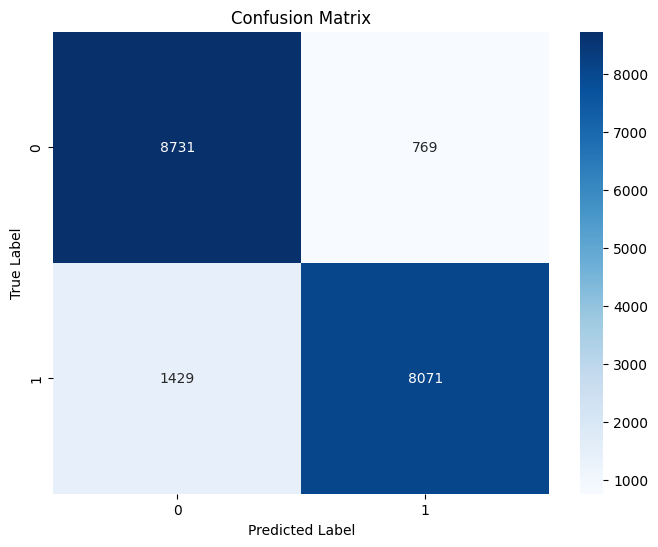


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      9500
           1       0.91      0.85      0.88      9500

    accuracy                           0.88     19000
   macro avg       0.89      0.88      0.88     19000
weighted avg       0.89      0.88      0.88     19000


Evaluating Student Model...


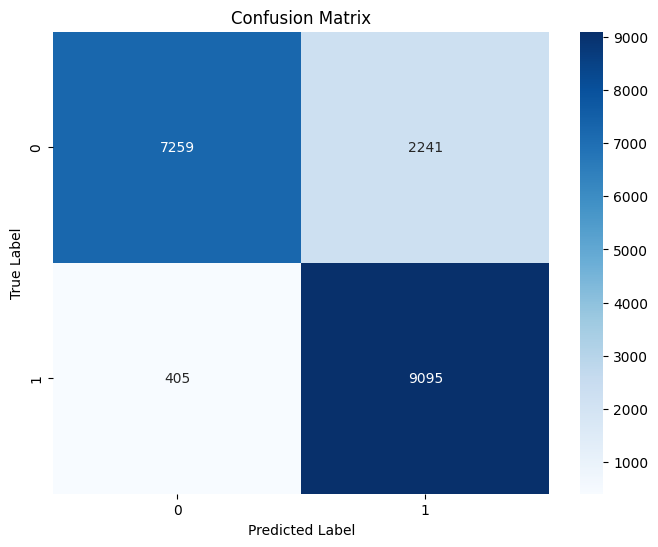


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      9500
           1       0.80      0.96      0.87      9500

    accuracy                           0.86     19000
   macro avg       0.87      0.86      0.86     19000
weighted avg       0.87      0.86      0.86     19000



In [26]:
if __name__ == "__main__":
    main()

In [17]:
import os

# Specify the folder path and suffix
folder_path = "/kaggle/input/final-final-ds/corrected_dataset/train/FAKE"
suffix = "Pgd.jpg"  # Replace with your desired suffix

# Check if any file with the given suffix exists
suffix_exists = any(f.endswith(suffix) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)))

if suffix_exists:
    print(f"Files with the suffix '{suffix}' exist in the directory.")
else:
    print(f"No files with the suffix '{suffix}' found in the directory.")


No files with the suffix 'Pgd.jpg' found in the directory.


In [18]:
import shutil

folder_to_download = '/kaggle/input/final-final-ds/corrected_dataset/test/FAKE'  # Specify the folder path
output_zip = 'Trial.zip'      # Name of the zip file

# Compress the folder
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_download)
print("Folder zipped successfully!")


Folder zipped successfully!
